<a href="https://colab.research.google.com/github/Tzu-Liang/COMP64101-Reasoning-and-Learning-under-Uncertainty-Module/blob/main/Labs/comp64101_coursework_part1_a49626th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Brief: Statistical Inference and Gaussian processes

## Deadline: November 18, 2025, 14:00 GMT

## Number of marks available: 35

This coursework is made of two parts. In the first part, you will explore different techniques for approximate inference. In the second part, you will use Bayesian optimisation for hyperparameter learning.

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

A. A **Jupyter Notebook** with the code in all the cells executed and outputs displayed.

B. Name your Notebook **COM64101_Assignment_part1_XXXXXX.ipynb** where XXXXXX is your username such as such as abc18de. Example: `COM64101_Assignment_abc18de.ipynb`

C. Upload the Jupyter Notebook in B to Canvas under the submission area before the deadline.

D. **NO DATA UPLOAD**: Please do not upload the data files used in this Notebook. We have a copy already.


### Assessment Criteria

* Being able to correctly apply frequentist, Bayesian, Monte Carlo, importance sampling, and variational inference methods as specified in each task.

* Being able to provide clear comparisons between methods (e.g., MLE vs. Bayesian, plain MC vs. IS, VI vs. HMC) using appropriate metrics, plots, and variance/uncertainty evaluations.

* Being able to use Gaussian processes as a surrogate model for Bayesian optimisation of the hyperparameters of a machine learning model.

* Being able to concisely explain results, justify methodological choices, and discuss observed differences within the given word limits.

### Code quality and use of Python libraries
When writing your code, you will find out that there are operations that are repeated at least twice. If your code is unreadable, we may not award marks for that section. Make sure to check the following:

* Did you include Python functions to solve the question and avoid repeating code?
* Did you comment your code to make it readable to others?

### Late submissions

We follow Department's guidelines about late submissions, i.e., a deduction of 10% of the mark each 24 hours the work is late after the deadline. NO late submission will be marked one week after the deadline. Please read [this link](https://documents.manchester.ac.uk/display.aspx?DocID=29825).

### Academic malpractice

**Any form of unfair means is treated as a serious academic offence and action may be taken under the Discipline Regulations.** Please carefully read [what constitutes Academic Malpractice](https://documents.manchester.ac.uk/display.aspx?DocID=2870) if not sure. If you still have questions, please ask your Personal tutor or the Lecturers.

# 1. Statistical Inference (20 marks)

Section 1 of this coursework is made of three parts (Part 1.1, Part 1.2, and Part 1.3). Complete the tasks below. Do **not** modify the provided datasets.

For Part 1.1, you need to analyze coin-flip data using both frequentist (MLE + Wald CI) and Bayesian (Beta prior + posterior sampling) methods, compare their predictions for future flips, and understand the differences. For Part 1.2, you need to estimate a 2D integral using plain Monte Carlo and importance sampling. For Part 1.3, you need to fit Bayesian logistic regression using both mean-field variational inference and HMC, compare their posterior approximations (via KL divergence and test log-loss).

## 1.1 Bayesian vs. Frequentist Modelling (5 marks)

In this exercise, you will explore two different statistical paradigms—**frequentist inference** and **Bayesian inference**—applied to the problem of estimating a coin’s probability of landing heads. The dataset `coin_experiments.csv` contains 1,000 independent coin-flip experiments, each recording the number of **successes** (heads) and the total **trials**.  

**Question**

**1.1.A.** The frequentist approach treats the probability of success, $p$, as a fixed but unknown quantity. You will:  
- Import the data, print its shape, and check basic sanity (e.g., no missing values, successes ≤ trials). **(0.5 pt)**  
- Compute the **Maximum Likelihood Estimate (MLE)**, $\hat{p} = S/N$, where $S$ is the total number of successes and $N$ is the total number of trials. **(1 pt)**
-  Estimate the standard error,  
  $$\text{SE} = \sqrt{\hat{p}(1-\hat{p})/N},$$  
  and form a **95% Wald confidence interval** using $z = 1.96$. **(0.5 pt)**

**Answer**

In [1]:
import pandas as pd
import numpy as np

# Read the dataset (coin_experiments) stored on GitHub
url = "https://raw.githubusercontent.com/Tzu-Liang/COMP64101-Reasoning-and-Learning-under-Uncertainty-Module/main/Labs/datasets_part_1/coin_experiments.csv"
data = pd.read_csv(url) # Load the dataset

print("The shape of the dataset:", data.shape) # shape
print("\nThe 1st 5 rows of the dataset:\n",data.head()) # 1st 5 rows

# Basic sanity checks
print("\nMissing values:\n", data.isna().sum()) # Missing values

# Check if successes ≤ trials
# all() returns true when all values in column are true, otherwise false
if (data['successes'] <= data['trials']).all():
  print("\nGood: successes ≤ trials for all rows")
else:
  print("\nBad: successes > trials in some rows", data[data['successes'] > data['trials']])

# Check for non-negative values
if (data['successes'] < 0).any() or (data['trials'] < 0).any():
    print("Negative values in the dataset")
else:
    print("All values are non-negative\n")

# Compute MLE, SE, and form a 95% Wald confidence interval
# total successes and total trials
S = data['successes'].sum()
N = data['trials'].sum()

# Compute MLE
p_hat = S/N
print(f"Maximum Likelihood Estimate (MLE) p̂ = {p_hat:.6f}")

# Compute SE
SE = np.sqrt(p_hat*(1-p_hat)/N) # SE
print(f"Standard Error (SE) = {SE:.6f}")

# 95% Wald confidence interval
# P(-1.96 <= Z <= 1.96) = 0.95
z = 1.96
CI_lower = p_hat - z * SE
CI_upper = p_hat + z * SE
print(f"With 95% confident, the probability of heads lies between {CI_lower:.6f} and {CI_upper:.6f}")

The shape of the dataset: (1000, 2)

The 1st 5 rows of the dataset:
    successes  trials
0         29      48
1         18      38
2         17      24
3         10      17
4         18      30

Missing values:
 successes    0
trials       0
dtype: int64

Good: successes ≤ trials for all rows
All values are non-negative

Maximum Likelihood Estimate (MLE) p̂ = 0.600303
Standard Error (SE) = 0.002812
With 95% confident, the probability of heads lies between 0.594791 and 0.605815


**Question**

**1.1.B.** The Bayesian approach treats $p$ as a **random variable** with prior distribution. Using a **Beta(1, 1)** prior (uniform), you will:  
- Compute the posterior parameters,  
  $$\alpha_{\text{post}} = \alpha_0 + S, \quad \beta_{\text{post}} = \beta_0 + (N-S),$$  
  and the **MAP estimate**,  
  $$p_{\text{MAP}} = \frac{\alpha_{\text{post}} - 1}{\alpha_{\text{post}} + \beta_{\text{post}} - 2}.$$
  **(1 pt)**
- Draw at least 5,000 samples from the Beta posterior (e.g., `scipy.stats.beta.rvs`). **(0.5 pt)**

**Answer**

Maximum a posteriori estimate (MAP) estimate: 0.600303


Text(0, 0.5, 'Density')

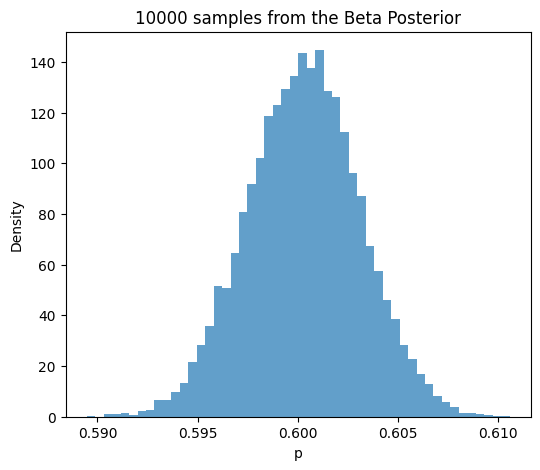

In [2]:
from scipy.stats import beta
import matplotlib.pyplot as plt

# Compute posterior parameters, MAP estimate, and draw samples from Beta posterior
# Beta(alpha_0 = 1, beta_0 = 1)
alpha_0, beta_0 = 1, 1

# Posterior parameters
alpha_post = alpha_0 + S
beta_post = beta_0 + (N-S)
p_map = (alpha_post - 1) / (alpha_post + beta_post - 2) # Maximum a posteriori estimate
print(f"Maximum a posteriori estimate (MAP) estimate: {p_map:.6f}")

# Generate samples
n_samples = 10000
posterior_samples = beta.rvs(alpha_post, beta_post, size=n_samples)

# Visualisation
plt.figure(figsize=(6, 5))

plt.hist(posterior_samples, density = True, bins=50, alpha = .7)
plt.title(f"{n_samples} samples from the Beta Posterior")
plt.xlabel('p')
plt.ylabel('Density')

**Question**

**1.1.C.** Finally, compare predictions for the next **20 flips**:  
- From the Bayesian model, simulate posterior predictive outcomes by sampling from a **Binomial(20, p)** where $p$ comes from the posterior samples, and show a histogram/density. **(0.5 pt)**
- From the frequentist model, plot the **plug-in Binomial pmf** with $p = \hat{p}_{\text{MLE}}$ over the same figure.**(0.5 pt)**

**Answer**

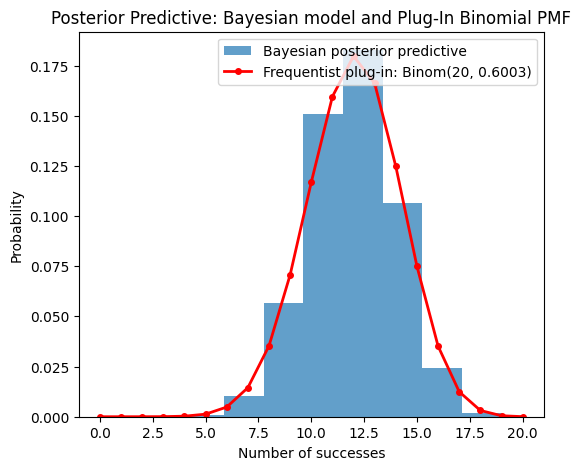

In [3]:
from scipy.stats import binom

# Bionomial distribution
# Numer of trials
n_binomial = 20

# Posterior predictive: P(X_new | data) = ∫ Likelihood × Posterior dp
posterior_predictive_samples = [
    np.random.binomial(n_binomial, posterior_sample)
    for posterior_sample in posterior_samples         # Monte Carlo
]

# Direct plug-in Binomial pmf
k = np.arange(0, n_binomial + 1) # Range of possible successes
pmf = binom.pmf(k, n_binomial, p_hat) # Binomial pmf

# Visulaisation
plt.figure(figsize=(6, 5))

# Density plot for posterior predictive samples
plt.hist(posterior_predictive_samples,
         density = True,
         bins = 8,
         alpha = .7,
         label = 'Bayesian posterior predictive')

# Plug-in Bionomial pmf
plt.plot(k,
         pmf,
         'ro-',
         linewidth = 2,
         markersize = 4,
         label = f'Frequentist plug-in: Binom(20, {p_hat:.4f})')
plt.title("Posterior Predictive: Bayesian model and Plug-In Binomial PMF")
plt.xlabel("Number of successes")
plt.ylabel("Probability")
plt.legend()

-+
**Question**

**1.1.D.** Write a short explanation comparing the two predictive distributions. Comment on how the Bayesian posterior predictive accounts for uncertainty in $p$, while the frequentist plug-in relies on a single point estimate. **(0.5 pt)**


**Answer**

The posterior predicitve combines the prior belief with the likelihood estimate of the observed data, weighted by their posteiror probabilities. It natually accounts for uncertainty in $p$, so it provides smoother predictions and thus reduces the possiblity of overfitting the datapoints. In contrast, the frequentist plug-in only uses a single point estimate (MLE) for $p$, ignoring the uncertainty in $p$. It tends to deviate more from the true posterior predictive. Hence, it provides less reliable predictions, though it is computationally simpler to implement.

## 1.2 Variance Reduction with Importance Sampling (5 marks)

Many integrals that arise in statistics and machine learning cannot be evaluated analytically, especially in higher dimensions. **Monte Carlo (MC) integration** is a general technique to approximate such integrals by drawing random samples from a distribution and averaging function evaluations. Although MC estimators are unbiased, their variance can be large, meaning we may need many samples to reach a desired accuracy.  

A way to improve efficiency is through **importance sampling (IS)**. Instead of sampling from a fixed distribution (e.g., Gaussian), we choose a proposal distribution $q(x)$ that better matches the regions where the integrand contributes most. By reweighting samples, we can reduce variance while keeping the estimator unbiased. The effectiveness of IS depends critically on choosing $q(x)$ with heavier tails or shapes aligned with the integrand.  

In this exercise, you will evaluate a 2D integral and demonstrate how importance sampling can achieve significant variance reduction compared to plain Monte Carlo:  

$$
I = \int_{\mathbb{R}^2} \exp(-\|x\|_1)\,\sin(\|x\|_2)\,dx,
$$  

with the goal of achieving an **absolute error < 0.01**.  

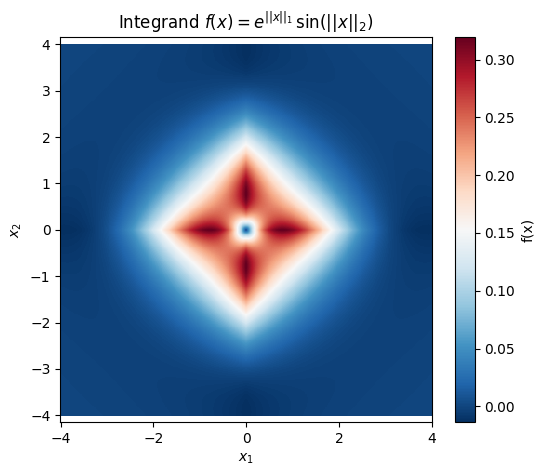

In [4]:
# Visualize the integrand
import numpy as np
import matplotlib.pyplot as plt

def integrand(x):
    l1 = np.sum(np.abs(x), axis=-1)   # L1 norm
    l2 = np.linalg.norm(x, axis=-1)   # L2 norm
    return np.exp(-l1) * np.sin(l2)

# grid
xx, yy = np.meshgrid(np.linspace(-4,4,400), np.linspace(-4,4,400))
pts = np.stack([xx,yy], axis=-1)
zz = integrand(pts)

# plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xx, yy, zz, cmap="RdBu_r", shading="auto")
plt.colorbar(label="f(x)")
plt.title("Integrand $f(x) = e^{||x||_1} \\, \\sin(||x||_2)$")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.axis("equal")
plt.show()


**Question**

**1.2.A. Plain Monte Carlo (2 pts)**  
   - Estimate $I$ by sampling $x \sim \mathcal{N}(0, I_2)$ using the plain Monte Carlo estimator **(1 pt)**:  
     $$
     \hat{I} = \frac{1}{N} \sum_{i=1}^N f(x_i), \quad x_i \sim \mathcal{N}(0, I_2).
     $$  
   - Report your estimate $\hat{I}$ and the **empirical standard error**. Verify that the error decreases as $N$ increases. **(1 pt)**

**Answer**

**The estimate of $I$ using the plain Monte Carlo should be
$$\hat{I} = \frac{1}{N}\sum_{i=1}^N\frac{f(x_i)}{p(x_i)},$$
where $p(x_i)$ are Gaussian density at $x_i$.**

In [5]:
from scipy.stats import multivariate_normal as mvn

# Plain Monte Carlo (MC)
def MC_integration(N = 5000):
    '''
    N: numner of samples
    x_samples: samples from a Gaussian distribution N(0, I_2)
    f_x_samples: corresponding function values
    '''
    # 2-dimensional Identity
    I2 = np.eye(2)

    # Compute f(x), where the samples x are from bivaraiate normal distribution
    x_samples = np.random.multivariate_normal(np.zeros(2), I2, N)
    f_x_samples = integrand(x_samples)

    # Compute Gaussian distribution: p(x)
    p_dist = mvn(mean= np.zeros(2), cov= I2)
    p_x_samples = p_dist.pdf(x_samples)

    # Weights: f/p
    weights = f_x_samples / p_x_samples

    # MC estimate
    I_hat = np.mean(weights)

    # Standard deviation and empirical standard error
    std = np.std(weights)
    empirical_SE = std / np.sqrt(N)
    return I_hat, empirical_SE

In [6]:
# Number of samples
n_samples = 100000

I_hat, empirical_SE = MC_integration(N = n_samples)
print(f"{n_samples} samples from the Gaussian distribution:")
print(f"Plain MC estimate of I: {I_hat:.6f}")
print(f"Empirical standard error using plain MC: {empirical_SE:.6f}")

100000 samples from the Gaussian distribution:
Plain MC estimate of I: 2.329309
Empirical standard error using plain MC: 0.039587


Text(0.5, 1.0, 'Plain Monte Carlo: standard error')

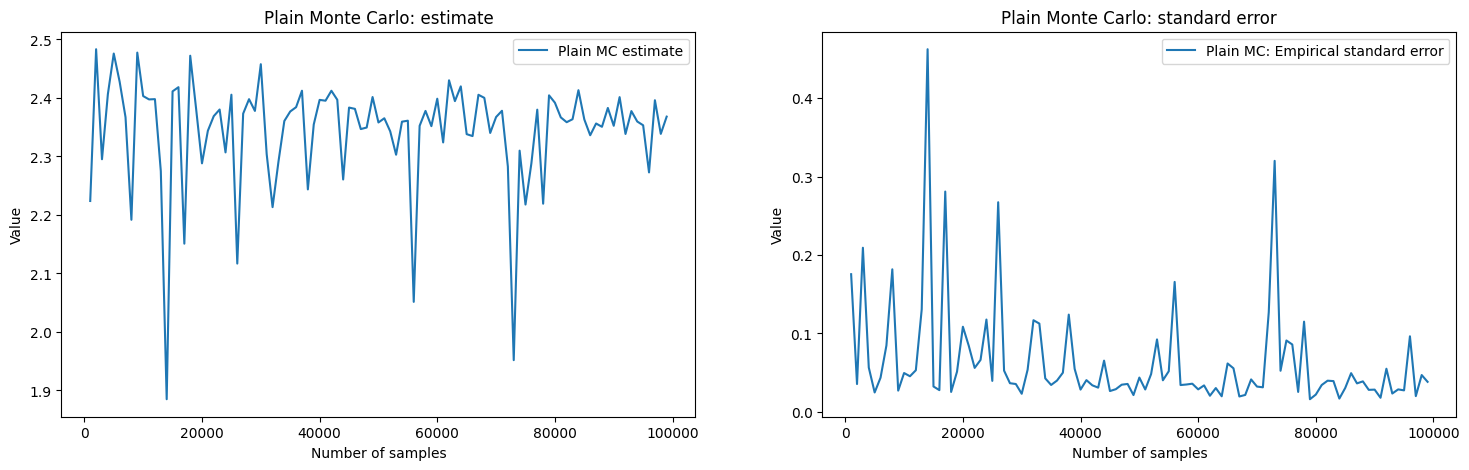

In [7]:
# Numbers of samples
N = np.arange(1000, n_samples, 1000)

# MC estimates given different numbers of samples
I_hats = []
empirical_SEs = []
for n in N:
    I_hat, empirical_SE = MC_integration(n)
    I_hats.append(I_hat)
    empirical_SEs.append(empirical_SE)

# Visualisation
plt.figure(figsize=(18,5))

# Plain MC estimate
plt.subplot(1, 2, 1)
plt.plot(N, I_hats, label = "Plain MC estimate")
plt.xlabel("Number of samples")
plt.ylabel("Value")
plt.legend()
plt.title("Plain Monte Carlo: estimate")

# Plain MC standard error
plt.subplot(1,2,2)
plt.plot(N, empirical_SEs, label = "Plain MC: Empirical standard error")
plt.xlabel("Number of samples")
plt.ylabel("Value")
plt.legend()
plt.title("Plain Monte Carlo: standard error")

In [8]:
from scipy import integrate

# Compute true value of the integral and the absolute erorr for plain MC estimate
def integrand_wrapper(x2, x1):
    return integrand(np.array([x1, x2]))

# Integrate over first quadrant and multiply by 4 (due to symmetry)
result, error = integrate.dblquad(
    integrand_wrapper,
    0, np.inf,  # x1 from 0 to infinity
    0, np.inf,   # x2 from 0 to infinity
    epsabs=1e-12,
    epsrel=1e-12
)

# Multiply by 4 due to symmetries in two axes
result *= 4

print(f"The true value of integral: {result:.6f}")
print(f"Plain MC estimate of I: {I_hat:.6f}")
print(f"The absolute error for plain MC estimate: {np.abs(result - I_hat):.6f}")

The true value of integral: 2.347128
Plain MC estimate of I: 2.368040
The absolute error for plain MC estimate: 0.020912


**Question**

**1.2.B Importance Sampling (1.5 pts)**  
   - Design your own proposal distribution $q(x)$ and implement an importance sampling estimator.**(1 pt)**
   - Demonstrate a **variance reduction** for an equal number of samples **(0.5 pt)**
   - *Hint:* Consider proposals (e.g., Laplace, Student-t or other) to better capture the integrand’s structure.  

**Answer**

In [9]:
def proposal_distribution(x):
    '''
    Proposal_distirbution is proportional to the integrand
    It would give a lower variance of importance weight
    Hence, I here choose a Laplace distribution
    '''
    # Norm 1
    l1 = np.sum(np.abs(x), axis=-1)
    return np.exp(-l1)/4

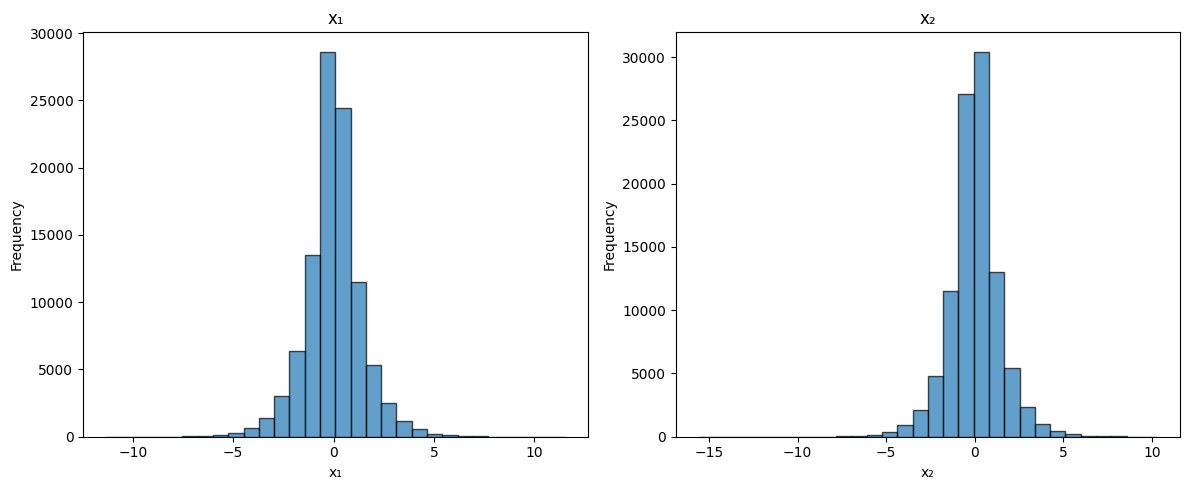

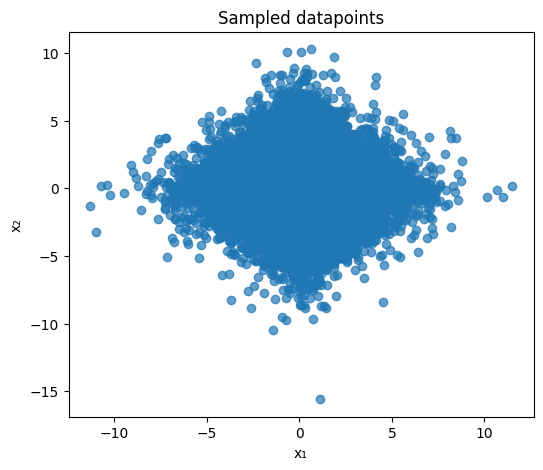

In [10]:
# Generate samples from the propsoal distribution
laplace_samples = np.random.laplace(loc=0, scale=1, size=(n_samples, 2))

# Visualisation of each axis x1 and x2
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(laplace_samples[:, 0], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('x₁')
plt.ylabel('Frequency')
plt.title('x₁')

plt.subplot(1, 2, 2)
plt.hist(laplace_samples[:, 1], bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('x₂')
plt.ylabel('Frequency')
plt.title('x₂')

plt.tight_layout()
plt.show()

# Visulaise the generated samples
plt.figure(figsize=(6, 5))

plt.scatter(laplace_samples[:, 0], laplace_samples[:, 1], alpha=0.7)
plt.xlabel('x₁')
plt.ylabel('x₂')
plt.title('Sampled datapoints')
plt.show()

In [11]:
def importance_sampling(N = 10000):
    '''
    N: numner of samples
    q(x): proposal distribution
    proposed_samples: Samples from Laplace distribution
    1/N * sum(f/q), where f(x) is the integrand and q(x) is the proposal distribution
    '''
    # Samples from Laplace distribution
    proposed_samples = np.random.laplace(loc=0, scale=1, size=(N, 2))

    # Importance weights: true distribution / proposal distribution
    weights = integrand(proposed_samples) / proposal_distribution(proposed_samples)

    # Estimate and empirical standard error
    I_hat = np.mean(weights)
    empirical_SE = np.std(weights) / np.sqrt(N)

    return I_hat, empirical_SE

I_hat, empirical_SE = importance_sampling(N = n_samples)
print(f"{n_samples} samples from the Laplace distribution:")
print(f"Importance sampling estimate of I: {I_hat:.6f}")
print(f"Empirical standard error using Importance sampling: {empirical_SE:.6f}")

100000 samples from the Laplace distribution:
Importance sampling estimate of I: 2.336791
Empirical standard error using Importance sampling: 0.005910


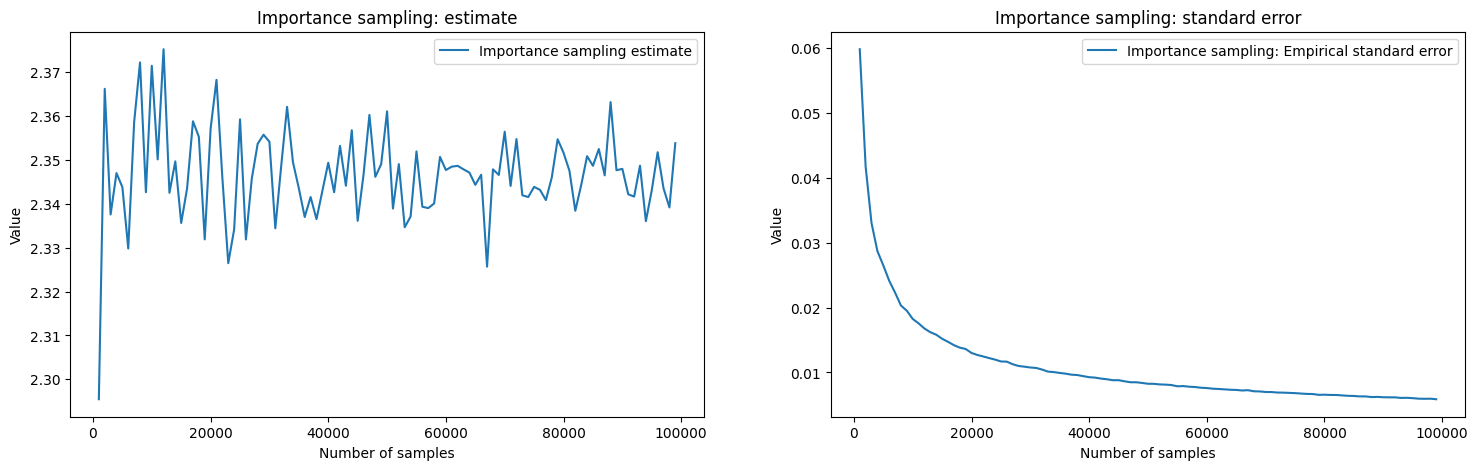

In [12]:
# Compute estimates given different numbers of samples
I_hats = []
empirical_SEs = []
for n in N:
    I_hat, empirical_SE = importance_sampling(N = n)
    I_hats.append(I_hat)
    empirical_SEs.append(empirical_SE)

# Visualisation
plt.figure(figsize=(18,5))

# Plain MC estimate
plt.subplot(1, 2, 1)
plt.plot(N, I_hats, label = "Importance sampling estimate")
plt.xlabel("Number of samples")
plt.ylabel("Value")
plt.legend()
plt.title("Importance sampling: estimate")

# Plain MC standard error
plt.subplot(1,2,2)
plt.plot(N, empirical_SEs, label = "Importance sampling: Empirical standard error")
plt.xlabel("Number of samples")
plt.ylabel("Value")
plt.legend()
plt.title("Importance sampling: standard error")
plt.show()

In [13]:
# The absolute error for importance sampling
print(f"The true value of integral: {result:.6f}")
print(f"Importance sampling estimate of I: {I_hat:.6f}")
print(f"The absolute error for importance sampling: {np.abs(result - I_hat):.6f}")

The true value of integral: 2.347128
Importance sampling estimate of I: 2.353832
The absolute error for importance sampling: 0.006704


**Question**

**1.2.C RMSE Comparison (1 pt)**  
   - Produce a **log–log plot** of RMSE vs. sample size $N$, comparing plain Monte Carlo and importance sampling. **(1 pt)**  
   - Use $N \in [10^3, 10^5]$ (e.g., 5–10 log-spaced points). Ensure both curves are clearly labeled.

**Answer**

In [14]:
def rmse(y_true, y_pred):
    '''
    Calculate RMSE
    '''
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

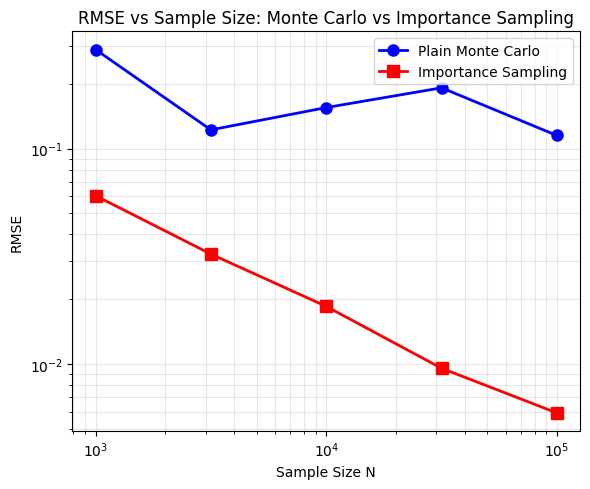

In [15]:
# Sample sizes
N_values = np.logspace(3, 5, 5).astype(int)
trials = 200

# Collect multiple estimates for each N
I_hats_MC = []
for n in N_values:
    estimates = []
    for _ in range(trials):
        I_hat, _ = MC_integration(n)
        estimates.append(I_hat)
    I_hats_MC.append(estimates)

I_hats_importance = []
for n in N_values:
    estimates = []
    for _ in range(trials):
        I_hat, _ = importance_sampling(N=n)
        estimates.append(I_hat)
    I_hats_importance.append(estimates)

# Compute RMSE
rmse_MC = [rmse(result, np.array(estimates)) for estimates in I_hats_MC]
rmse_importance = [rmse(result, np.array(estimates)) for estimates in I_hats_importance]


# Create log-log plot
plt.figure(figsize=(6, 5))

plt.loglog(N_values, rmse_MC, 'o-', linewidth=2, markersize=8,
           label='Plain Monte Carlo', color='blue')
plt.loglog(N_values, rmse_importance, 's-', linewidth=2, markersize=8,
           label='Importance Sampling', color='red')


plt.xlabel('Sample Size N')
plt.ylabel('RMSE')
plt.title('RMSE vs Sample Size: Monte Carlo vs Importance Sampling')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()

plt.show()

**Question**

**1.2.D. Justification (0.5 pt)**  
   - Explain your choice of proposal $q(x)$. Discuss how it aligns with the shape of the integrand and why it reduces variance relative to Gaussian sampling. **(0.5 pt)**

**Answer**
My proposal function is defined as
$$q(x)=\exp(-\|x\|_1).$$
Here are the reasons:


1.   Good overlap with the integrand: $q(x)$ closely match the shapes and the tails of the target integrand $\exp(-\|x\|_1)\,\sin(\|x\|_2)$, while Gaussian proposal decays too quickly. This good overlap guarantees that the importance weight $w = \frac{p(x)}{q(x)}$ is bounded, resulting in a small second moment of $w$. A smaller second moment of $w$ corresponds to lower variance in the estimate $\hat{I}$, so this propsoal $q$ yields a more reliable estimate.

2.  Easy sampling: The proposal $q(x)$ is a Laplace distribution. It has many analytical properties, leading to efficient sampling.



## 1.3 Mean-Field Variational Inference for Bayesian Logistic Regression (10 marks, ★ difficult)

In this exercise, you will implement **Bayesian logistic regression** and approximate its posterior distribution using **mean-field variational inference (VI)**. You will then compare VI with a **Hamiltonian Monte Carlo (HMC)** benchmark to highlight the trade-offs between computational efficiency and posterior accuracy. The dataset `log_reg_data.csv` contains predictors `x1, x2, …` and a binary label `y`.

### Background & Motivation

- **Bayesian logistic regression** models uncertainty in the regression weights $w$, allowing you to quantify predictive uncertainty rather than relying only on a point estimate (as in standard logistic regression). The prior is chosen as a Gaussian:  
  $$
  w \sim \mathcal{N}(0, 10I).
  $$  

- **Variational Inference (VI)** approximates the true posterior $p(w \mid D)$ by a simpler distribution. Here, we use a **mean-field Gaussian**:  
  $$
  q_\phi(w) = \mathcal{N}(w \mid \mu, \mathrm{diag}(\sigma^2)),
  $$  
  where the parameters $\phi = (\mu, \sigma)$ are optimised to make $q_\phi$ close to the true posterior.  

- Optimisation is done via the **Evidence Lower Bound (ELBO)**:  
  $$
  \mathcal{L}(\phi) = \mathbb{E}_{q_\phi}[ \log p(D \mid w) ] - \mathrm{KL}(q_\phi \,\|\, p(w)),
  $$  
  which we estimate stochastically using the **reparameterisation trick**:  
  $$
  w = \mu + \sigma \odot \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
  $$  

- **Hamiltonian Monte Carlo (HMC)** provides a high-fidelity posterior approximation by simulating from the exact Bayesian posterior using gradient information. It is computationally more expensive but is often treated as the “gold standard” for comparison.  

By completing this task, you will see how VI provides a fast but approximate solution, while HMC is slower but more accurate. The comparison highlights the **bias–variance trade-off** in approximate inference.
**Hint:**  
- Use `autograd` for gradients in VI.  
- Clip `log_sigma` to avoid extreme variances.  
- Use `scipy.special.expit` for the logistic function.  
- For HMC, you can rely on **NumPyro** (already available) to avoid implementing HMC from scratch.

**Question**

**1.3.A Variational Inference (3 pts)**  
   - Construct the VI family and implement the **reparameterised ELBO**. Optimise with SGD/ADAM. **(2 pt)**
   - Show a training curve of the ELBO to confirm convergence. **(1 pt)**

In [16]:
!pip install autograd

In [17]:
import numpy as np
import pandas as pd
from autograd import grad
import autograd.numpy as anp
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from autograd.scipy.special import expit

**Answer**

In [18]:
class VI:
    """
    Variational inference
    """
    def __init__(self, d, prior_mean, prior_var):
        """
        d: number of features
        Initial parameters: mean = 0 and log_sigma = 1
        Using log_sigma avoids negative variance after optimisation
        """
        self.d = d
        self.prior_mean = prior_mean
        self.prior_var = prior_var
        self.mu = anp.zeros(d)
        self.log_sigma = anp.ones(d)

    def log_likelihood(self, w, X, y):
        """
        log-likelihood: log P(y|X, w)
        X: input data
        y: output data
        w: weights
        """
        x_dot_w = anp.dot(X, w) # X @ w

        sigmoid_xw = anp.clip(expit(x_dot_w), 1e-8, 1 - 1e-8) # avoid log(0) or log(1)

        # log P(y|X, w) = log (Pi P(y_i|x_i, w)) (Sigmoid functions sigma(y_i)^y_i * (1-siga(y_i))^(1-y_i))
        log_lik = anp.sum(y * anp.log(sigmoid_xw) + (1 - y) * anp.log(1 - sigmoid_xw))
        return log_lik

    def reparameterisation(self, mu, log_sigma):
        """
        w = mu + sigma * epsilon
        mu: mean for posterior
        log_sigma: log sigma for posterior
        """
        sigma = anp.exp(log_sigma)
        epsilon = np.random.randn(self.d)

        return mu + sigma * epsilon

    def expected_log_likelihood(self, mu, log_sigma, X, y, n_mc):
        """ expected_log_likelihood: E[log P(y|X, w)] wrt posterior
        q n_mc: number of samples for MC
        """
        expected_log_lik = 0.0

        for i in range(n_mc):
            w = self.reparameterisation(mu, log_sigma)
            expected_log_lik += self.log_likelihood(w, X, y)

        expected_log_lik /= n_mc

        return expected_log_lik

    def kl_divergence(self, mu, log_sigma):
        """
        KL divergence from posterior to prior
        mu: mean for posterior
        log_sigma: log sigma for posterior
        """
        # variance for posterior and prior
        var_q = anp.exp(2 * log_sigma)
        var_p = self.prior_var

        diff_mu = mu - self.prior_mean

        # After integrating the kl function

        kl = 0.5 * anp.sum(anp.log(var_p) -
                           anp.log(var_q) -
                           1.0 +
                           (var_q / var_p)+
                           (diff_mu**2 / var_p)
                           )

        return kl

    def elbo(self, params, X, y, n_mc):
        """
        ELBO: Evidence Lower Bound with clipped log_sigma
        """
        mu, log_sigma = params[:self.d], params[self.d:]
        log_sigma = anp.clip(log_sigma, -10, 10)

        expected_log_lik = self.expected_log_likelihood(mu, log_sigma, X, y, n_mc)
        kl = self.kl_divergence(mu, log_sigma)

        return expected_log_lik - kl

    def fit(self, X, y, n_iter, lr, n_mc):
        """
        n_iter: number of iterations
        lr: learning rate
        n_mc: number of samples for MC
        Using SGD to maximise ELBO
        """
        mu = self.mu
        log_sigma = self.log_sigma

        params = anp.concatenate([mu, log_sigma])

        grad_negative_elbo = grad(lambda p: self.elbo(p, X, y, n_mc))

        elbos = []

        for _ in range(n_iter):
            g = grad_negative_elbo(params)
            params = params + lr * g
            elbos.append(self.elbo(params, X, y, n_mc))

        self.mu = params[:self.d]
        self.log_sigma = params[self.d:]

        return elbos

In [19]:
# Load data
url = "https://raw.githubusercontent.com/Tzu-Liang/COMP64101-Reasoning-and-Learning-under-Uncertainty-Module/main/Labs/datasets_part_1/log_reg_data.csv"
data = pd.read_csv(url)

print("The shape of the dataset:", data.shape) # shape
print("\nThe 1st 5 rows of the dataset:\n",data.head()) # 1st 5 rows

# Prepare data for input X and output Y
y = data['y'].values
X = data.drop('y', axis=1).values

# Elements in the 1st column are 1
X = np.column_stack([np.ones(X.shape[0]), X])
print(f"Shape of input:{X.shape}")

The shape of the dataset: (10000, 21)

The 1st 5 rows of the dataset:
          x1        x2        x3        x4        x5        x6        x7  \
0  0.032004 -0.753418  0.459972 -0.677715  2.013387  0.136535 -0.365322   
1 -0.322680 -0.250833  1.328194  0.556230  0.455888  2.165002 -0.643518   
2 -0.221254 -0.276813  0.307407  0.815737  0.860473 -0.583077 -0.167122   
3  1.238283  0.021272  0.308833  1.702215  0.240753  2.601683  0.565510   
4 -1.195883  0.444603  1.196631 -0.609783 -0.134017  0.014688 -0.784898   

         x8        x9       x10  ...       x12       x13       x14       x15  \
0  0.184680 -1.347126 -0.971614  ... -0.656894 -1.046911  0.536653  1.185704   
1  0.927840  0.057013  0.268592  ...  0.507836  0.538296  1.072507 -0.364953   
2  0.282580 -0.248691  1.607346  ...  0.734878  0.662881  1.173474  0.181022   
3 -1.760763  0.753342  0.381158  ...  0.673181 -0.138456 -1.224298 -0.209023   
4  0.648280 -0.120948  0.419532  ... -0.437458  0.722381 -0.372833  1.726964  

In [20]:
from sklearn.model_selection import train_test_split
# 30% test, 70% train
X, X_test, y, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    shuffle=True
)

print("Training set shape:", X.shape, y.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (7000, 21) (7000,)
Test set shape: (3000, 21) (3000,)


In [21]:
# Number of features
d = X.shape[1]

# Prior parameters
prior_mean = 0.0
prior_var = 10.0

# Build VI model with 5-time MC
vi_model = VI(d, prior_mean, prior_var)
elbo_history = vi_model.fit(X = X,
                            y = y,
                            n_iter = 100,
                            lr = .001,
                            n_mc = 5)

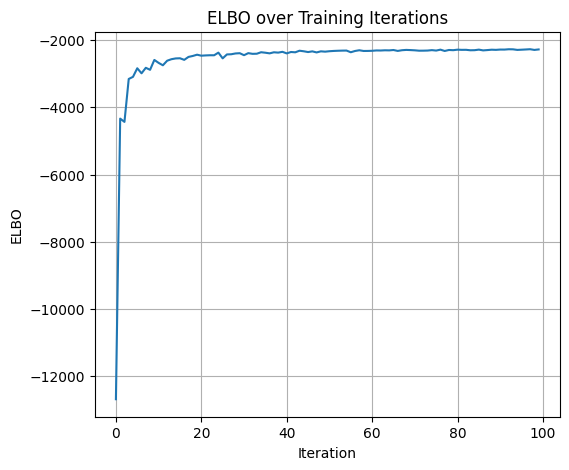

In [22]:
plt.figure(figsize=(6, 5))
plt.plot(elbo_history)
plt.title("ELBO over Training Iterations")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.grid(True)
plt.show()

JAX is a Python library that works like NumPy but adds extra features such as automatic differentiation and faster computations. NumPyro is a library built on JAX that makes it easier to do Bayesian statistics and probabilistic modeling. You should use JAX together with NumPyro, complete the following task:

**Question**

**1.3.B HMC Benchmark (2 pt)**  
   - Run **4 parallel HMC chains** (NumPyro/Stan acceptable) to obtain ≥1,000 effective samples.  
   - Report convergence diagnostics ($\hat{R} \leq 1.05$).  

In [23]:
!pip install jax==0.4.31
!pip install jaxlib==0.4.31
!pip install numpyro

  Using cached jax-0.4.31-py3-none-any.whl.metadata (22 kB)
  Using cached jaxlib-0.4.31-cp312-cp312-manylinux2014_x86_64.whl.metadata (983 bytes)
Using cached jax-0.4.31-py3-none-any.whl (2.0 MB)
Using cached jaxlib-0.4.31-cp312-cp312-manylinux2014_x86_64.whl (88.2 MB)
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.7.2
    Uninstalling jaxlib-0.7.2:
      Successfully uninstalled jaxlib-0.7.2
  Attempting uninstall: jax
    Found existing installation: jax 0.7.2
    Uninstalling jax-0.7.2:
      Successfully uninstalled jax-0.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.10.7 requires jax>=0.6.0, but you have jax 0.4.31 which is incompatible.
orbax-checkpoint 0.11.28 requires jax>=0.6.0, but you have jax 0.4.31 which is incompatible.
optax 0.2.6 requires jax>=0.5.3, but you have jax 0.4.31 which is incompatible.
optax 0.2

In [24]:
import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import summary

**Answer**

In [25]:
class HMC:
    def __init__(self, prior_mean, prior_var):
        self.prior_mean = prior_mean
        self.prior_var = prior_var

    def logistic_regression_model(self, X, y):
        """
        Bayesian logistic regression model
        """
        n_features = X.shape[1]

        # P(w) ~ N(mean = 0, var = 10)
        w = numpyro.sample('w', dist.Normal(self.prior_mean, jnp.sqrt(self.prior_var)).expand([n_features]))

        # P(y|X, w) ~ Bernoulli(sigmoid(X @ w))
        X_dot_w = jnp.dot(X, w)
        numpyro.sample('obs', dist.Bernoulli(logits = X_dot_w), obs = y)

    def sampling(self, X, y, n_warmup, n_samples, n_chains):
        """
        Run HMC with 4 parallel chains
        n_warmup: burn-in samples
        n_chains: number of independent start points
        """
        # Setup NUTS sampler: compute gradient of log P(w|X,y) [posterior]
        nuts_kernel = NUTS(lambda X, y: self.logistic_regression_model(X, y))

        # Run MCMC
        mcmc = MCMC(nuts_kernel,
                    num_warmup = n_warmup,
                    num_samples = n_samples,
                    num_chains = n_chains)
        mcmc.run(random.PRNGKey(0), X, y)

        # Get samples and diagnostics
        samples = mcmc.get_samples()
        diagnostics = summary(samples, prob=0.95)

        return samples, diagnostics

In [26]:
hmc_model = HMC(prior_mean, prior_var)

hmc_samples, h_mc_diagnostics = hmc_model.sampling(jnp.array(X),
                jnp.array(y),
                n_warmup = 2000,
                n_samples = 2000,
                n_chains = 4)

w_stats = h_mc_diagnostics['w']
R_max = w_stats['r_hat'].max()
print(f"\nR-hat: max = {R_max:.4f}")
print(f"{'Converged' if R_max <= 1.05 else 'Not converged'}")

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/jax/_src/xla_bridge.py", line 609, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.12/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 348, in initialize
    xla_client.register_custom_type_id_handler(
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jaxlib.xla_client' has no attribute 'register_custom_type_id_handler'. Did you mean: 'register_custom_call_handler'?
/tmp/ipython-input-128972531.py:29: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_devic


R-hat: max = 1.0113
Converged


**Question**

**1.3.C Posterior Comparison (3 pts)**  
   - Compute $\mathrm{KL}(q_\phi \parallel p(w \mid D))$ using HMC samples as the reference posterior. **(2 pt)**  
   - Compute test-set log-loss under both VI and HMC. Present results in a table or plot. **(1 pt)**

In [27]:
import numpy as np
from sklearn.metrics import log_loss
from scipy.special import expit

**Answer**

In [28]:
# mu and mean of samples from HMC
mu_hmc = np.mean(hmc_samples['w'], axis = 0)
var_hmc = np.var(hmc_samples['w'], axis = 0)

# VI parameters
var_q = anp.exp(2 * vi_model.log_sigma)
diff_mu = vi_model.mu - mu_hmc

# Assuming P(w|X,y) is a Gaussian distribution with diagonal covariances
kl = 0.5 * anp.sum(anp.log(var_hmc) -
                    anp.log(var_q) -
                    1.0 +
                    (var_q / var_hmc)+
                    (diff_mu**2 / var_hmc))

print("KL divergence between propsoed posterior and likelihood sampled from HMC: ", kl)

KL divergence between propsoed posterior and likelihood sampled from HMC:  30.809938


In [29]:
def predictive_probs(X, w_samples):
        """
        X: (N, D)
        w_samples: (S, D)
        Returns predictive probabilities p(y=1 | x) using MC averaging.
        """
        logits = X @ w_samples.T              # (N, S)
        probs = expit(logits)                 # sigmoid
        return probs.mean(axis=1)

In [30]:
probs_hmc = predictive_probs(jnp.array(X_test), jnp.array(hmc_samples['w']))
logloss_hmc = log_loss(y_test, probs_hmc)
print(f"Test log-loss (HMC): {logloss_hmc:.6f}")

# 1000 weight samples
eps = np.random.randn(1000, d)   # (1000, D)
w_vi_samples = vi_model.mu + np.exp(vi_model.log_sigma) * eps         # (1000, D)

probs_vi = predictive_probs(X_test, w_vi_samples)
logloss_vi = log_loss(y_test, probs_vi)
print(f"Test log-loss (VI): {logloss_vi:.6f}")

Test log-loss (HMC): 0.305279
Test log-loss (VI): 0.306662


**Question**

**1.3.D Discussion (2 pt)**  
   - Discuss where VI diverges from HMC. Comment on underestimation of uncertainty, mode-seeking bias, and the speed vs. accuracy trade-off.  


**Answer**

**VI**


1.  Method: optimisation
2.  Finds the best approximation distribution from the Gaussian family by maximising ELBO
3.  Underestimates the uncertainty of the true posterior
4.  Accuracy usaully is lower
5.  In this case, it has a single modality
6.  More efficient

**HMC**


1.   Method: sampling (simulates Hamiltonian dynamics)
2.   Samples from the true posterior
3.   The uncertainty is close to the true posterior
4.   Accuracy ususallyis higher
5.   It can have multimodality
6.   Less efficient

# 2. Gaussian processes and Bayesian Optimisation (15 marks)

This part of the coursework uses Gaussian processes for Bayesian optimisation of the hyperparameters of a Machine Learning model. The dataset you will use in this assignment comes from a popular machine learning repository that hosts open source datasets for educational and research purposes, the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). The task is  to predict electrical energy output from a [combined cycle Power Plant](https://en.wikipedia.org/wiki/Combined_cycle_power_plant). The description of the dataset can be found [here](https://archive.ics.uci.edu/dataset/294/combined+cycle+power+plant).

## Bayesian optimisation of Elastic net hyperparameters

You will use Thompson Sampling (TS) for hyperparemeter learning of an [elastic net model for regression](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net) over the electrical energy output dataset. Before moving on, please read the mathematical description of the Elastic net model [here](https://scikit-learn.org/stable/modules/linear_model.html#elastic-net). The two hyperparameters to optimise will be the $\alpha>0$ parameter and the $0\le\rho\le1$ parameter. The $\alpha$ and $\rho$ hyperparameters are related to the level of $\ell_1$ and $\ell_2$ regularisaion done for the linear regression model. The exact relationship between these parameters is explained [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet).

The function we want to minimise will be the Root Mean-Squared Error (RMSE) on a validation dataset,

\begin{align}
    \text{RMSE}(\alpha, \rho) = \sqrt{\text{MSE}(\mathbf{y}_\text{val}, f(\mathbf{x}_{\text{val}}, \mathcal{D}_\text{train}, \alpha, \rho))},
\end{align}

where $\text{MSE}(\mathbf{y}_\text{val}, f(\mathbf{x}_{\text{val}}, \mathcal{D}_\text{train}, \alpha, \rho))$ is the Mean-Squared error between the validation data and the prediction of the elastic net model, which in turn is a function of the training data, $\mathcal{D}_\text{train}$, and the hyperparameters $\alpha$ and $\rho$.

**IMPORTANT. You can use scikit-learn for implementing the Elastic Net regressor. You can also use any library for the Gaussian process surrogate model. However, you CAN NOT use any package for the Bayesian optimisation loop. Failure to follow these instructions, will lead to a mark of zero for this section of the assignment.**

We will first load the dataset and split it into training, validation and test sets.

In [31]:
import urllib.request
doq = "https://archive.ics.uci.edu/static/public/294/combined+cycle+power+plant.zip"
pat_sav = "./combined+cycle+power+plant.zip"
urllib.request.urlretrieve(doq, pat_sav)

('./combined+cycle+power+plant.zip',
 <http.client.HTTPMessage at 0x78c20f753a40>)

In [32]:
import zipfile
zip = zipfile.ZipFile('./combined+cycle+power+plant.zip', 'r')
for name in zip.namelist():
    zip.extract(name, '.')

In [33]:
import pandas as pd
import numpy as np
energy_output = pd.read_excel('./CCPP/Folds5x2_pp.xlsx','Sheet1')

The dataset has 9568 observations. We will use a subset of $N_m$ for this exercise. From those, we will select $80\%$ as the training data, $10\%$ as the validation data, and $10\%$ as the test data.

In [34]:
N_m = 9000
ndata, ncols = np.shape(energy_output)
np.random.seed(68736)                 # Make sure you use the last five digits of your student UCard as your seed
index = np.random.permutation(ndata)  # We permute the indexes
data_tot_red = energy_output.iloc[index[0:N_m], :].copy() # Select N_m points
Ne = np.int64(np.round(0.8*N_m))    # We compute N, the number of training instances
Neval = np.int64(np.round(0.1*N_m)) # We compute Nval, the number of validation instances
Netest = N_m - Ne - Neval              # We compute Ntest, the number of test instances
index = np.random.permutation(N_m)  # We permute the indexes
data_training = data_tot_red.iloc[index[0:Ne], :].copy() # Select the training data
data_val = data_tot_red.iloc[index[Ne:Ne+Neval], :].copy() # Select the validation data
data_test = data_tot_red.iloc[index[Ne+Neval:N_m], :].copy() # Select the test data

In [35]:
Xe_train = np.concatenate((np.ones((Ne,1)), (data_training.iloc[:, 0:4]).values), axis=1)
ye_train = np.reshape((data_training.iloc[:, 4]).values, (Ne,1))
Xe_val = np.concatenate((np.ones((Neval,1)), (data_val.iloc[:, 0:4]).values), axis=1)
ye_val = np.reshape((data_val.iloc[:, 4]).values, (Neval,1))
Xe_test = np.concatenate((np.ones((Netest,1)), (data_test.iloc[:, 0:4]).values), axis=1)
ye_test = np.reshape((data_test.iloc[:, 4]).values, (Netest,1))

### 2.1 Initial space filling-design (5 marks)

We start by collecting a few initial points from the function we want to optimise. Here, you will assume the first initial design has $n_0 = 5$ points. The ouput of this part of your code should be the data observations ``X0train`` and ``y0train``

**Answer**

In [36]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error

def rmse(alpha, rho, X_train, y_train, X_val, y_val):
    """
    alpha: Regularization parameter
    rho:   l1 ratio
    """
    elastic_net_regressor = ElasticNet(alpha = alpha,
                                       l1_ratio = rho,
                                       fit_intercept = False,
                                       max_iter = 10000,
                                       random_state = 68736)
    elastic_net_regressor.fit(X_train, y_train)
    y_val_pred = elastic_net_regressor.predict(X_val)

    return np.sqrt(mean_squared_error(y_val, y_val_pred))

In [37]:
# Number of initial datapoints
n_0 = 5

# alpha > 0 and 0 <= rho <= 1
alpha_min, alpha_max = 0.001, 10
rho_min, rho_max = 0.0, 1.0

# alpha_star and rho_star are the range of alpha and rho
n_grid = 50
alpha_star = np.linspace(alpha_min, alpha_max, n_grid)
rho_star = np.linspace(rho_min, rho_max, n_grid)
alpha_grid, rho_grid = np.meshgrid(alpha_star, rho_star)
X_test = np.column_stack([alpha_grid.ravel(), rho_grid.ravel()])

# Set the initial 5 values: X0train
np.random.seed(68736)
init_indices = np.random.permutation(len(X_test))[:n_0]
X0train = X_test[init_indices, :]

# Evaluate RMSE at these initial hyperparameters
y0train = []
for i, (alpha, rho) in enumerate(X0train):
    error = rmse(alpha, rho, Xe_train, ye_train, Xe_val, ye_val)
    y0train.append(error)
    print(f"Initial point {i+1}: alpha = {alpha:.4f}, rho = {rho:.4f}, RMSE = {error:.4f}")
y0train = np.array(y0train).reshape(-1,1)

Initial point 1: alpha = 0.6132, rho = 0.5714, RMSE = 5.1524
Initial point 2: alpha = 9.3878, rho = 0.1020, RMSE = 5.5150
Initial point 3: alpha = 5.3066, rho = 0.1837, RMSE = 5.3276
Initial point 4: alpha = 1.0213, rho = 0.5918, RMSE = 5.1534
Initial point 5: alpha = 7.3472, rho = 0.7143, RMSE = 5.3649


### 2.2 Implement the sequentail-decision loop to find the optimal set of hyperparameters (5 marks)

Assume your optimisation budget is equal to $N = 20$ function evaluations and implement your Bayesian optimiser. For each iteration in the optimisation, you need to:

1. Compute the posterior distribution of your Gaussian process using all available training data.
2. Use Thompson sampling to find the optimal value to explore next.
3. Observe your new output at the suggested optimal point.

At the end of the optimisation loop, you should return a value of $\alpha_*$ and $\rho_*$.

**Answer**

In [38]:
!pip install GPy

In [39]:
import numpy as np
import GPy
import matplotlib.pyplot as plt

# Delete the initial 5 points from X_test
X_test = np.delete(X_test, init_indices, axis=0)

def bayesian_optimisation(X_test,
                          X0train,
                          y0train,
                          Xe_train,
                          ye_train,
                          Xe_val,
                          ye_val,
                          max_iter = 20):
    """
    BO loops to find the minimum of rmse with maximal interation = 20
    """
    np.random.seed(68736)

    # Current minimum
    error_min_history = []
    error_min_history.append(np.min(y0train))

    # BO loops
    for _ in range(max_iter):
        # Kernel is Matern52
        kernel = GPy.kern.Matern52(input_dim = X0train.shape[1],
                            variance = 1,
                            lengthscale = 1)
        # GP
        gp_model = GPy.models.GPRegression(X0train, y0train, kernel)

        # Posterior mean, covariance
        mean, cov = gp_model.predict(X_test, full_cov=True)

        # Using Thompson sampling to obtain the next values of alpha and rho
        index = thompson_sampling(mean, cov)

        # Add new data
        X0train = np.vstack([X0train, X_test[index]])
        rmse_next = rmse(X_test[index, 0], X_test[index, 1], Xe_train, ye_train, Xe_val, ye_val)
        y0train = np.vstack([y0train, rmse_next])
        error_min_history.append(np.min(y0train))

        # Delete explored data
        X_test = np.delete(X_test, index, axis=0)

    # Visualisation
    plt.figure(figsize=(6, 5))
    plt.plot(error_min_history)
    plt.xlabel('Iteration')
    plt.ylabel('Best RMSE Found So Far')
    plt.title('BO')
    plt.grid(True, alpha=0.3)
    plt.show()

    index = np.argmin(y0train)
    return X0train[index], y0train[index]

def thompson_sampling(mean, cov):
    """
    return index from the acquisition function
    """
    # Thompson Sampling:
    # 1. Draw a single sample f* from the GP posterior N(mean, cov).
    # 2. Select the next points of alpha and rho as the locations where f* achieves its minimum.
    f_star = np.random.multivariate_normal(mean.flatten(), cov)
    index = np.argmin(f_star)

    return index

 /usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning:Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.543e+05, tolerance: 1.488e+05 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.


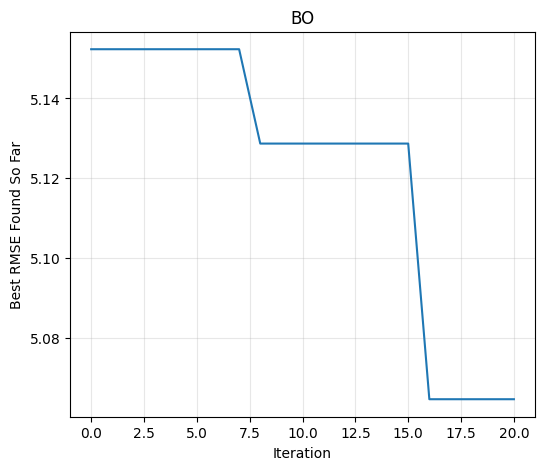

Total run time = 403.63


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [40]:
import time

start_time = time.time()
# Execute BO
para, error = bayesian_optimisation(X_test,
                          X0train,
                          y0train,
                          Xe_train,
                          ye_train,
                          Xe_val,
                          ye_val,
                          max_iter = 20)
print(f"Total run time = {time.time() - start_time:.2f}")
print(f"Optimal values: alpha = {para[0]:.4f}, rho = {para[1]:.4f}, rmse = {error:.4f}")

### 2.3 Compute RMSE in the test set and compare the performance of the Bayes Opt approach against an alterntive method for hyperparameter selection (5 marks)

Compute the performance of the Elastic Net model over the test set.

**Answer**

In [ ]:
# Final model with optimal alpha and rho on combined train+val data
elastic_net_regressor = ElasticNet(alpha = para[0],
                                    l1_ratio = para[1],
                                    fit_intercept = False,
                                    max_iter = 10000)

elastic_net_regressor.fit(np.vstack([Xe_train, Xe_val]),
                          np.vstack([ye_train, ye_val]))

# Predict on test set and its rmse
y_test_pred = elastic_net_regressor.predict(Xe_test)
error = np.sqrt(mean_squared_error(ye_test, y_test_pred))

print(f"RMSE for the test set: {error:.4f}")

Use an alternative approach for hyperparameter learning of $\alpha$ and $\rho$.

**Answer**

In [ ]:
def sgd(X_train, y_train, X_val, y_val,
                      alpha_init = 1.0, rho_init = 0.5,
                      learning_rate = 0.01, max_iter = 100):
    """
    Use SGD method with finite differences
    alpha_init : initial regularization parameter
    rho_init : initial l1_ratio
    learning_rate : step size for SGD
    max_iter : maximum iterations
    """

    # Initialize parameters
    # Use log scale for alpha as alpha > 0
    log_alpha = np.log(alpha_init)
    rho = rho_init

    history = []

    for iteration in range(max_iter):
        # Current parameters (valid region)
        alpha = np.exp(log_alpha)
        rho_valid = np.clip(rho, 0, 1)

        # Evaluate RMSE
        error = rmse(alpha, rho_valid, X_train, y_train, X_val, y_val)
        history.append(error)

        # Compute numerical gradients (finite differences)
        epsilon = 1e-5

        # Gradient wrt log_alpha
        alpha_plus = np.exp(log_alpha + epsilon)
        error_alpha = rmse(alpha_plus, rho_valid, X_train, y_train, X_val, y_val)
        grad_log_alpha = (error_alpha - error) / epsilon

        # Gradient wrt. rho
        rho_plus = np.clip(rho + epsilon, 0, 1)
        error_rho = rmse(alpha, rho_plus, X_train, y_train, X_val, y_val)
        grad_rho = (error_rho - error) / epsilon

        # SGD update
        log_alpha -= learning_rate * grad_log_alpha
        rho -= learning_rate * grad_rho

    # Visualisation
    plt.figure(figsize=(6, 5))
    plt.plot(history)
    plt.xlabel('Iteration')
    plt.ylabel('Current RMSE')
    plt.title('SGD')
    plt.grid(True, alpha=0.3)
    plt.show()

    return alpha, rho_valid, error

In [ ]:
start_time = time.time()

# Execute SGD
alpha, rho, error = sgd(Xe_train, ye_train, Xe_val, ye_val,
                      alpha_init = 1.0, rho_init = 0.5,
                      learning_rate = 0.5, max_iter = 500)
print(f"Total run time = {time.time() - start_time:.2f}")
print(f"Optimal values: alpha = {alpha:.4f}, rho = {rho:.4f}, rmse = {error:.4f}")

In [ ]:
# Final model with optimal alpha and rho on combined train+val data
elastic_net_regressor = ElasticNet(alpha = alpha,
                                    l1_ratio = rho,
                                    fit_intercept = False,
                                    max_iter = 10000)

elastic_net_regressor.fit(np.vstack([Xe_train, Xe_val]),
                          np.vstack([ye_train, ye_val]))

# Predict on test set and its rmse
y_test_pred = elastic_net_regressor.predict(Xe_test)
error = np.sqrt(mean_squared_error(ye_test, y_test_pred))

print(f"RMSE for the test set: {error:.4f}")

Write and discuss two interesting findings of this experiment.

- *Interesting finding 1*. Write a sentence here of no more than **30 words**.
- *Interesting finding 2*. Write a sentence here of no more than **30 words**.

**Answer**
1. SGD method minimises the cost function quickly (≈20 seconds), whereas BO requires substantially more time to optimise the parameters (≈400 seconds).

2. BO requires 25 evaluations, including 5 initial observations, to reach RMSE≈4.9908 on the test set, while SGD needs ~500 for RMSE≈5.0792. Thus, BO is far better for costly functions.